In [1]:
%reset -f

In [2]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import time
import kl_ucb_policy
import ts_bandit_policy

In [3]:
#Parameters for TS test
p = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #Bernoulli Parameters
# p = np.array([.95, .90, .80, .65, .45, .25, .15, .10])
# p = np.array([.90, .80, .70, .55, .45, .35, .20, .10])
rate = np.array([6, 9, 12, 18, 24, 36, 48, 54])
tp = np.multiply(p,rate)

K= p.shape[0] #Number of branches
Delta= ( np.ones(K)*np.max(tp) ) - tp
s = ts_bandit_policy.construct_s(rate, K)


T= 5000 #Time periods
runs = 1 #Number of iterations

print("Pi:",p)
print("Delta:",Delta)

Pi: [0.99 0.98 0.96 0.93 0.9  0.1  0.06 0.04]
Delta: [15.66 12.78 10.08  4.86  0.   18.   18.72 19.44]


## Thompson Sampling Bandit Simulation

In [4]:
# %%capture
c_ts = ts_bandit_policy.CBanditPolicy(K, rate, s, 0)
total_rewards_list_c_ts = np.zeros((runs, T))
actions_list_c_ts = []

ts = ts_bandit_policy.TSBanditPolicy(K, rate, 0)
total_rewards_list_ts = np.zeros((runs, T))
actions_list_ts = []

klucb = kl_ucb_policy.KLUCBPolicy(K, rate) #Original KL UCB
total_rewards_list_klucb = np.zeros((runs, T))
actions_list_klucb = []

start_time = time.time()

for run in range(runs):
    c_ts.reset()
    actions_c_ts = np.zeros((K, T), dtype=int)
    rewards_c_ts = np.zeros((K, T), dtype=float)

    ts.reset()
    actions_ts = np.zeros((K, T), dtype=int)
    rewards_ts = np.zeros((K, T), dtype=float)

    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=int)
    rewards_klucb = np.zeros((K, T), dtype=float)
    for t in range(T):
        c_ts.reduce_set()
        arm_c_ts = c_ts.select_next_arm()
        actions_c_ts[arm_c_ts, t] = 1
        rewards_c_ts[arm_c_ts, t] = np.random.binomial(1, p[arm_c_ts]) * rate[arm_c_ts]
        c_ts.update_state(arm_c_ts, int(rewards_c_ts[arm_c_ts, t] / rate[arm_c_ts]))

        arm_ts = ts.select_next_arm()
        actions_ts[arm_ts, t] = 1
        rewards_ts[arm_ts, t] = np.random.binomial(1, p[arm_ts]) * rate[arm_ts]
        ts.update_state(arm_ts, int(rewards_ts[arm_ts, t] / rate[arm_ts]))

        arm_klucb = klucb.select_next_arm()
        actions_klucb[arm_klucb, t] = 1
        rewards_klucb[arm_klucb, t] = np.random.binomial(1, p[arm_klucb]) * rate[arm_klucb]
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb, t] / rate[arm_klucb])

    cumulative_rewards_c_ts = np.cumsum(rewards_c_ts, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_c_ts = np.sum(cumulative_rewards_c_ts, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_c_ts[run, :] = np.copy(total_rewards_c_ts)
    actions_list_c_ts.append(np.copy(actions_c_ts))

    cumulative_rewards_ts = np.cumsum(rewards_ts, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_ts = np.sum(cumulative_rewards_ts, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_ts[run, :] = np.copy(total_rewards_ts)
    actions_list_ts.append(np.copy(actions_ts))

    cumulative_rewards_klucb = np.cumsum(rewards_klucb, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_klucb = np.sum(cumulative_rewards_klucb, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_klucb[run, :] = np.copy(total_rewards_klucb)
    actions_list_klucb.append(np.copy(actions_klucb))

time_spent = time.time() - start_time

D:\Academic\RateControl\Final_Version\Bandit_UCB\kl_ucb_policy.py:9: RuntimeWarning: divide by zero encountered in log
  result = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
D:\Academic\RateControl\Final_Version\Bandit_UCB\kl_ucb_policy.py:9: RuntimeWarning: invalid value encountered in double_scalars
  result = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))
D:\Academic\RateControl\Final_Version\Bandit_UCB\kl_ucb_policy.py:9: RuntimeWarning: invalid value encountered in log
  result = p * np.log(p/q) + (1-p)*np.log((1-p)/(1-q))


## Simulation Result

Time for Thompson Sampling, with T = 5000 , runs = 1 : 4.441002607345581 seconds
t & Reward (total) c_ts : 4999 106557.0
t & Reward (total) ts : 4999 106506.0
t & Reward (total) KL-UCB : 4999 105018.0


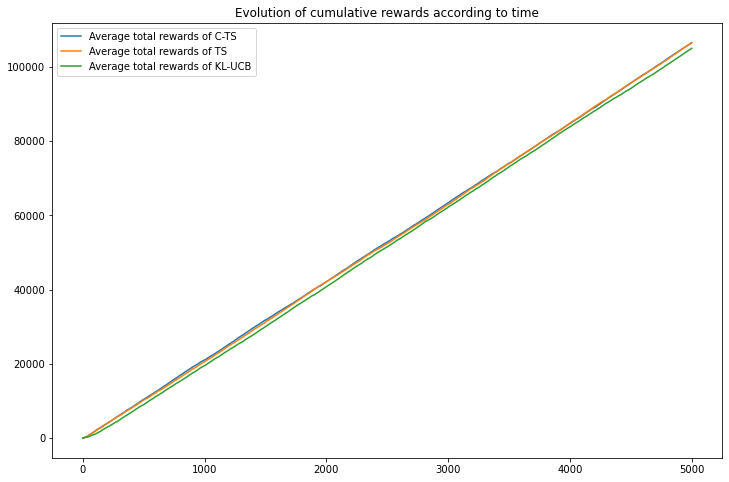

In [5]:
print("Time for Thompson Sampling, with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

## Average total rewards
mean_total_rewards_c_ts = np.mean(total_rewards_list_c_ts, axis=0)
mean_total_rewards_ts = np.mean(total_rewards_list_ts, axis=0)
mean_total_rewards_klucb = np.mean(total_rewards_list_klucb, axis=0)
print("t & Reward (total) c_ts :", t, mean_total_rewards_c_ts[t])
print("t & Reward (total) ts :", t, mean_total_rewards_ts[t])
print("t & Reward (total) KL-UCB :", t, mean_total_rewards_klucb[t])

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(mean_total_rewards_c_ts, linestyle='-', label='Average total rewards of C-TS')
ax1.plot(mean_total_rewards_ts, linestyle='-', label='Average total rewards of TS')
ax1.plot(mean_total_rewards_klucb, linestyle='-', label='Average total rewards of KL-UCB')
ax1.legend(loc='best')
ax1.set_title('Evolution of cumulative rewards according to time')
plt.show()

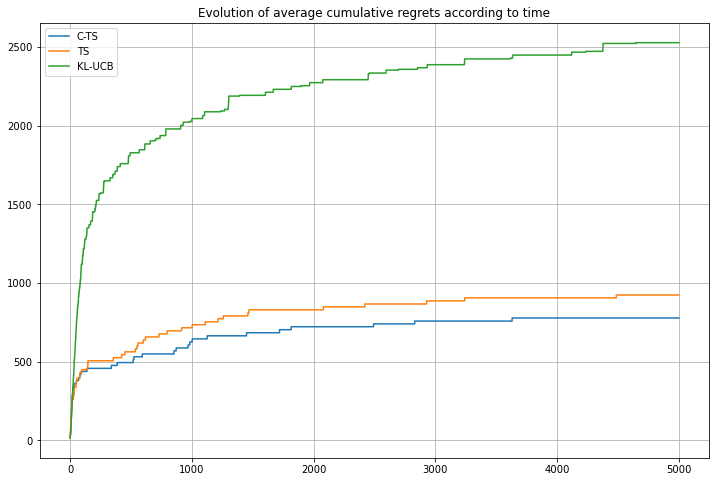

In [6]:
#Regrets calculation for TS
total_action_c_ts = np.zeros((K, T))
for actions_c_ts in actions_list_c_ts:
    total_action_c_ts += np.cumsum(actions_c_ts, axis=1)  #The cumulative times of each arm to be selected
total_action_c_ts = total_action_c_ts / runs
regret_cumule_c_ts = np.dot(Delta, total_action_c_ts[:, :])  # Cumulative regrets

total_action_ts = np.zeros((K,T))
for actions_ts in actions_list_ts:
    total_action_ts += np.cumsum(actions_ts, axis=1)  #The cumulative times of each arm to be selected
total_action_ts = total_action_ts / runs
regret_cumule_ts = np.dot(Delta, total_action_ts[:, :])  # Cumulative regrets

total_action_klucb = np.zeros((K, T))
for actions_klucb in actions_list_klucb:
    total_action_klucb += np.cumsum(actions_klucb, axis=1) #The cumulative times of each arm to be selected
total_action_klucb = total_action_klucb / runs
regret_cumule_klucb = np.dot(Delta, total_action_klucb[:, :]) # Cumulative regrec_ts

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(regret_cumule_c_ts[:], linestyle='-', label='C-TS')
ax1.plot(regret_cumule_ts[:], linestyle='-', label='TS')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
#ax1.xscale('log')
plt.show()